In this code note, I will present some time series techniques applied on activities sequences of human/bot users to predict number of activities to efficiently use Github api.

# Packages importing & visualisation

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

In [3]:
activities = pd.read_parquet('../data-raw/activities.parquet')

In [4]:
activities.sample(15)

,contributor,category,repository,activity,date
955156,437693,human,644848,Closing pull request,2023-03-14 22:41:43+00:00
401152,ballerina-bot,bot,ballerina-platform/ballerina-distribution,Creating branch,2023-02-11 22:30:45+00:00
459355,restyled-io[bot],bot,koromerzhin/labstag,Pushing commits,2023-02-22 15:28:55+00:00
787625,754548,human,654765,Commenting pull request,2022-12-14 15:01:27+00:00
767299,669693,human,957646,Deleting branch,2022-12-03 02:25:26+00:00
530449,octokit-fixture-user-a,bot,octokit-fixture-org/tmp-scenario-git-refs-2023...,Creating branch,2023-03-07 04:11:34+00:00
737801,codeclimate[bot],bot,Enterprise-CMCS/macpro-mdct-mcr,Commenting pull request,2023-04-12 17:51:49+00:00
993270,949698,human,939649,Deleting branch,2023-04-03 16:56:18+00:00
535536,codeclimate[bot],bot,belvo-finance/belvo-ruby,Commenting pull request changes,2023-03-07 21:18:37+00:00
411461,review-notebook-app[bot],bot,detmanski/project1,Commenting pull request,2023-02-14 03:41:13+00:00


In [53]:
df = activities.assign(date=pd.to_datetime(activities['date']).dt.date).groupby(['contributor', 'date']).activity.count().reset_index(name='activity_count')

In [54]:
df

,contributor,date,activity_count
0,0crat,2022-11-25,42
1,0crat,2022-11-26,3
2,0crat,2022-11-28,22
3,0crat,2022-11-29,44
4,0crat,2022-11-30,38
...,...,...,...
53348,zorro-bot[bot],2023-04-07,1
53349,zorro-bot[bot],2023-04-11,1
53350,zorro-bot[bot],2023-04-12,2
53351,zorro-bot[bot],2023-04-13,2


In [ ]:
# Grouping data by contributor and date, and summing up the activity counts
contributor_activity = df.groupby(['contributor', 'date']).sum().reset_index()

# Getting the top 4 contributors based on total activity counts
top_contributors = contributor_activity.groupby('contributor')['activity_count'].sum().nlargest(3).index

# Filtering data for the top 4 contributors
top_contributors_data = contributor_activity[contributor_activity['contributor'].isin(top_contributors)]

# Plotting the time series
plt.figure(figsize=(18, 10))
sns.lineplot(x='date', y='activity_count', hue='contributor', data=top_contributors_data)
plt.title('Time Series Plot of Activity Count for Top 4 Contributors')
plt.xlabel('Date')
plt.ylabel('Activity Count')
plt.show()


# Regression models

In [92]:
activity_count = activities.assign(date=pd.to_datetime(activities['date']).dt.date).groupby(['contributor', 'date']).activity.count().reset_index(name='activity_count')

# Grouping data by contributor and date, and summing up the activity counts
contributor_activity = activity_count.groupby(['contributor', 'date']).sum().reset_index()

# Getting the top contributor based on total activity counts
top_contributor = contributor_activity.groupby('contributor')['activity_count'].sum().idxmax()

# Filtering data for the top contributor
top_contributor_data = contributor_activity[contributor_activity['contributor'] == top_contributor]

# Renaming columns for linear regression compatibility
top_contributor_data = top_contributor_data.rename(columns={'date': 'day', 'activity_count': 'n_activities'})

data = top_contributor_data.drop(['contributor'], axis=1).reset_index(drop=True)

In [85]:
# Feature Engineering: create lag features based on the previous 10 dates
for i in range(1, 71):
    data[f'n_activities_lag_{i}'] = data['n_activities'].shift(i)

data.iloc[10:].reset_index(drop=True)

,day,n_activities,n_activities_lag_1,n_activities_lag_2,n_activities_lag_3,n_activities_lag_4,n_activities_lag_5,n_activities_lag_6,n_activities_lag_7,n_activities_lag_8,n_activities_lag_9,n_activities_lag_10,n_activities_lag_11,n_activities_lag_12,n_activities_lag_13,n_activities_lag_14,n_activities_lag_15,n_activities_lag_16,n_activities_lag_17,n_activities_lag_18,n_activities_lag_19,n_activities_lag_20,n_activities_lag_21,n_activities_lag_22,n_activities_lag_23,n_activities_lag_24,n_activities_lag_25,n_activities_lag_26,n_activities_lag_27,n_activities_lag_28,n_activities_lag_29,n_activities_lag_30,n_activities_lag_31,n_activities_lag_32,n_activities_lag_33,n_activities_lag_34,n_activities_lag_35,n_activities_lag_36,n_activities_lag_37,n_activities_lag_38,n_activities_lag_39,n_activities_lag_40,n_activities_lag_41,n_activities_lag_42,n_activities_lag_43,n_activities_lag_44,n_activities_lag_45,n_activities_lag_46,n_activities_lag_47,n_activities_lag_48,n_activities_lag_49,n_activities_lag_50,n_activities_lag_51,n_activities_lag_52,n_activities_lag_53,n_activities_lag_54,n_activities_lag_55,n_activities_lag_56,n_activities_lag_57,n_activities_lag_58,n_activities_lag_59,n_activities_lag_60,n_activities_lag_61,n_activities_lag_62,n_activities_lag_63,n_activities_lag_64,n_activities_lag_65,n_activities_lag_66,n_activities_lag_67,n_activities_lag_68,n_activities_lag_69,n_activities_lag_70
0,2022-12-05,314,183.0,173.0,219.0,404.0,321.0,450.0,313.0,111.0,191.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-06,359,314.0,183.0,173.0,219.0,404.0,321.0,450.0,313.0,111.0,191.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-12-07,452,359.0,314.0,183.0,173.0,219.0,404.0,321.0,450.0,313.0,111.0,191.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-12-08,539,452.0,359.0,314.0,183.0,173.0,219.0,404.0,321.0,450.0,313.0,111.0,191.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-12-09,361,539.0,452.0,359.0,314.0,183.0,173.0,219.0,404.0,321.0,450.0,313.0,111.0,191.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2023-04-11,317,477.0,120.0,149.0,233.0,354.0,369.0,520.0,603.0,232.0,204.0,481.0,417.0,500.0,455.0,630.0,143.0,308.0,592.0,514.0,442.0,479.0,735.0,108.0,245.0,431.0,677.0,568.0,554.0,610.0,219.0,237.0,398.0,515.0,446.0,544.0,556.0,169.0,295.0,321.0,599.0,464.0,380.0,514.0,249.0,273.0,339.0,352.0,324.0,365.0,412.0,151.0,165.0,283.0,321.0,318.0,399.0,463.0,125.0,170.0,310.0,393.0,391.0,344.0,521.0,95.0,223.0,491.0,420.0,350.0,333.0
128,2023-04-12,429,317.0,477.0,120.0,149.0,233.0,354.0,369.0,520.0,603.0,232.0,204.0,481.0,417.0,500.0,455.0,630.0,143.0,308.0,592.0,514.0,442.0,479.0,735.0,108.0,245.0,431.0,677.0,568.0,554.0,610.0,219.0,237.0,398.0,515.0,446.0,544.0,556.0,169.0,295.0,321

Mean Squared Error: 12783.585559491246


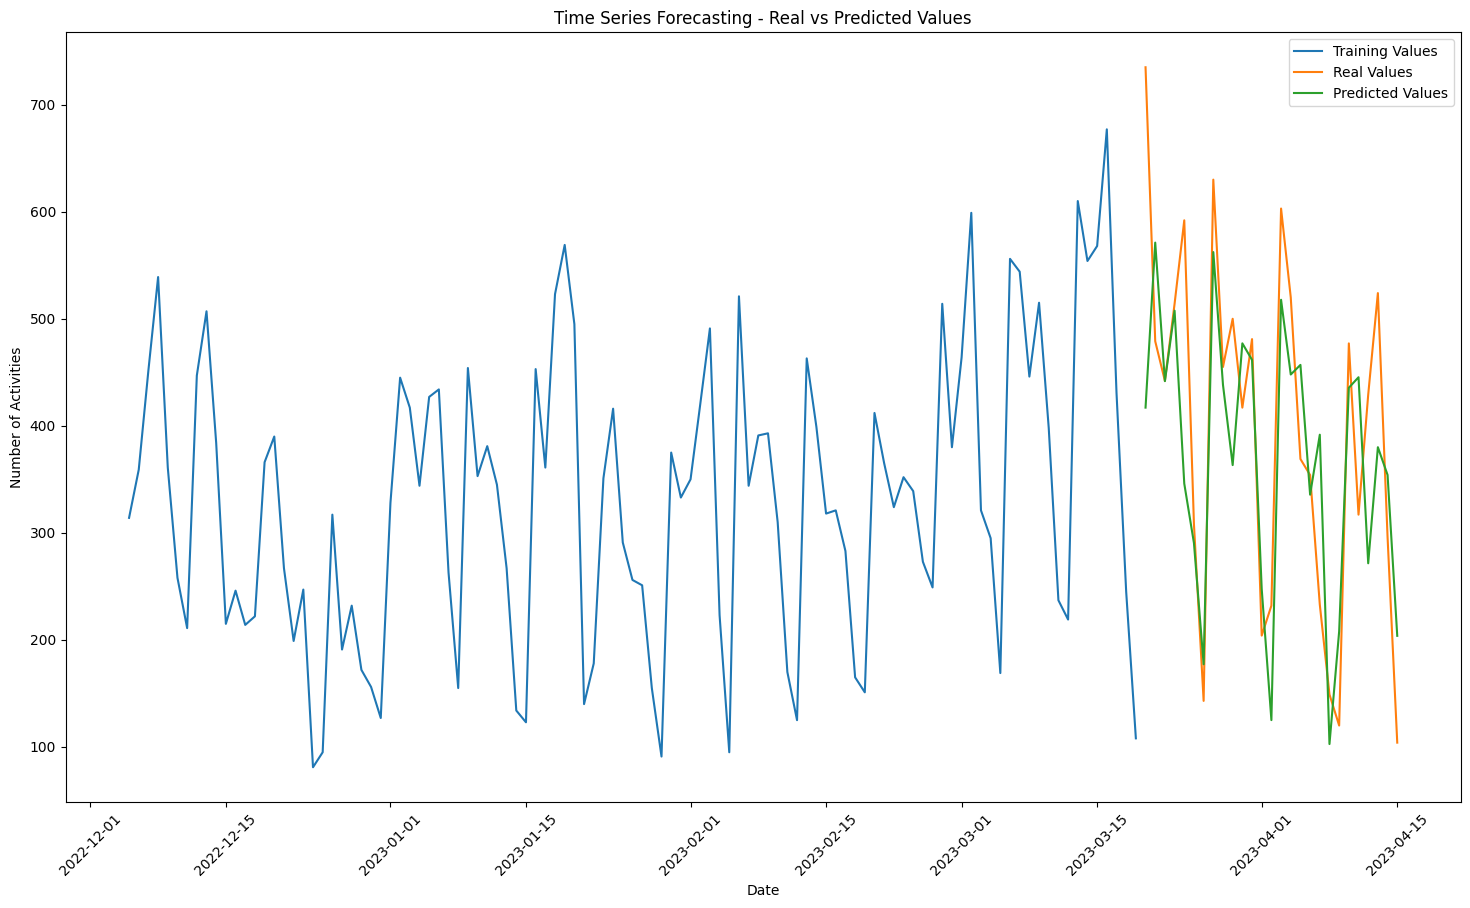

In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Bla bla
activity_count = activities.assign(date=pd.to_datetime(activities['date']).dt.date).groupby(['contributor', 'date']).activity.count().reset_index(name='activity_count')

# Grouping data by contributor and date, and summing up the activity counts
contributor_activity = activity_count.groupby(['contributor', 'date']).sum().reset_index()

# Getting the top contributor based on total activity counts
top_contributor = contributor_activity.groupby('contributor')['activity_count'].sum().idxmax()

# Filtering data for the top contributor
top_contributor_data = contributor_activity[contributor_activity['contributor'] == top_contributor]

# Renaming columns for linear regression compatibility
top_contributor_data = top_contributor_data.rename(columns={'date': 'day', 'activity_count': 'n_activities'})

data = top_contributor_data.drop(['contributor'], axis=1).reset_index(drop=True)


# Feature Engineering: create lag features based on the previous 10 dates
for i in range(1, 11):
    data[f'n_activities_lag_{i}'] = data['n_activities'].shift(i)

data = data.iloc[10:].reset_index(drop=True)

# Split the data into training and test sets (last 20% of the data)
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Separate features and target variable for training
X_train = train_data.drop(['day', 'n_activities'], axis=1)
y_train = train_data['n_activities']

# Separate features and target variable for testing
X_test = test_data.drop(['day', 'n_activities'], axis=1)
y_test = test_data['n_activities']

# Train the time series forecasting model with multiple linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions)

print(f'Mean Squared Error: {mse}')

# Visualize Results
plt.figure(figsize=(18, 10))
sns.lineplot(x=train_data['day'], y=train_data['n_activities'], label='Training Values')
sns.lineplot(x=test_data['day'], y=test_data['n_activities'], label='Real Values')
sns.lineplot(x=test_data['day'], y=predictions, label='Predicted Values')
plt.title('Time Series Forecasting - Real vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Number of Activities')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [74]:
for lag in range(1, 11):
    df[f"lag_{lag}"] = df["n_activities"].shift(lag)

In [75]:
df = df.iloc[10:].reset_index(drop=True).head(40)

In [65]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [67]:
from sklearn.linear_model import LinearRegression

X_train = train.drop(columns=['ds', 'y'])
y_train = train['y']

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [68]:
X_test = test.drop(columns=['ds', 'y'])
predictions = model.predict(X_test)

In [69]:
predictions

array([400.34118726, 217.11959367, 258.1756555 , 325.03393649,
       370.85125602, 429.59405846, 374.78515596, 266.75553861])

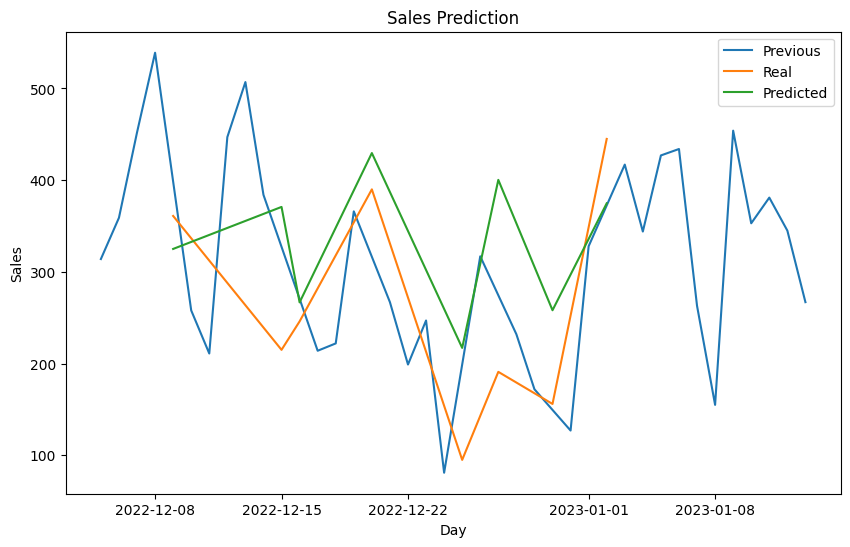

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=train, x='ds', y='y', label='Previous')
sns.lineplot(data=test, x='ds', y='y', label='Real')
sns.lineplot(x=test['ds'], y=predictions, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales Prediction')
plt.legend()
plt.show()

In [26]:
# Grouping data by contributor and date, and summing up the activity counts
contributor_activity = df.groupby(['contributor', 'date']).sum().reset_index()

# Getting the top contributor based on total activity counts
top_contributor = contributor_activity.groupby('contributor')['activity_count'].sum().idxmax()

# Filtering data for the top contributor
top_contributor_data = contributor_activity[contributor_activity['contributor'] == top_contributor]

# Renaming columns for linear regression compatibility
top_contributor_data = top_contributor_data.rename(columns={'date': 'ds', 'activity_count': 'y'})

# Splitting data into training and test sets
train_size = int(len(top_contributor_data) * 0.8)
train_data, test_data = top_contributor_data[:train_size], top_contributor_data[train_size:]

In [31]:
# Training the linear regression model
X_train = np.arange(len(train_data)).reshape(-1, 1)
y_train = train_data['y'].values.reshape(-1, 1)

model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
X_test = np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1)
y_pred = model.predict(X_test)

In [36]:
y_pred

array([[400.73593552],
       [402.0331193 ],
       [403.33030308],
       [404.62748686],
       [405.92467064],
       [407.22185441],
       [408.51903819],
       [409.81622197],
       [411.11340575],
       [412.41058953],
       [413.7077733 ],
       [415.00495708],
       [416.30214086],
       [417.59932464],
       [418.89650842],
       [420.1936922 ],
       [421.49087597],
       [422.78805975],
       [424.08524353],
       [425.38242731],
       [426.67961109],
       [427.97679486],
       [429.27397864],
       [430.57116242],
       [431.8683462 ],
       [433.16552998],
       [434.46271375],
       [435.75989753],
       [437.05708131]])

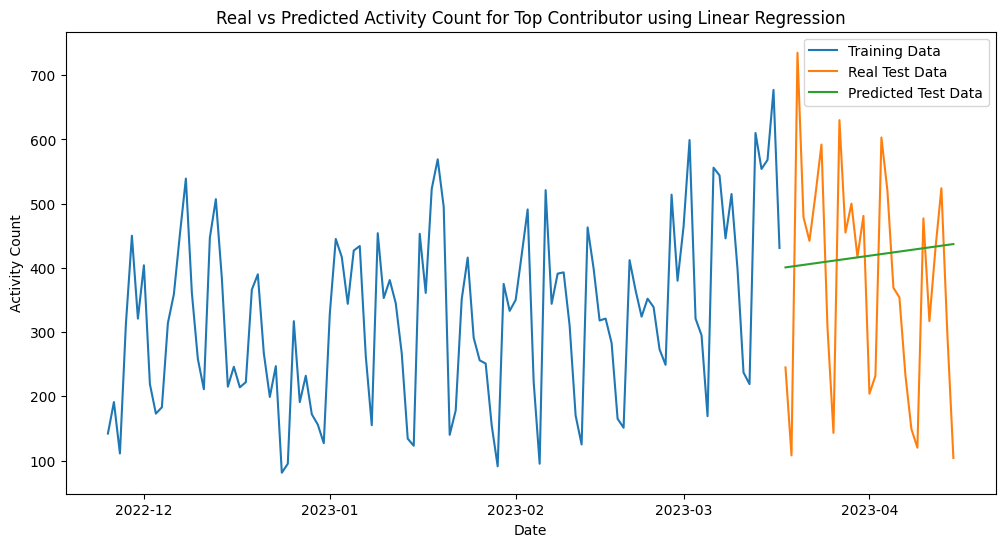

In [35]:
# Plotting the real and predicted plots
plt.figure(figsize=(12, 6))
plt.plot(top_contributor_data['ds'][:train_size], y_train, label='Training Data')
plt.plot(top_contributor_data['ds'][train_size:], test_data['y'], label='Real Test Data')
plt.plot(top_contributor_data['ds'][train_size:], y_pred, label='Predicted Test Data')
plt.title('Real vs Predicted Activity Count for Top Contributor using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Activity Count')
plt.legend()
plt.show()